In [2]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from waste_type_mapping import waste_type_mapping

import matplotlib.pyplot as plt
import numpy as np
import os
import json

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [3]:
DATASET_DIR = r"C:\Users\Guman Behera\Downloads\Recycle waste classification\images\images"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

print("Dataset exists:", os.path.exists(DATASET_DIR))


Dataset exists: True


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes detected:", class_names)
print("Number of classes:", len(class_names))


Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.
Classes detected: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Number of classes: 30


In [5]:
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("class_names.json saved")


class_names.json saved


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [10]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 299ms/step - accuracy: 0.6064 - loss: 1.3622 - val_accuracy: 0.7603 - val_loss: 0.7912
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 110s 292ms/step - accuracy: 0.7623 - loss: 0.7539 - val_accuracy: 0.7950 - val_loss: 0.6560
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 110s 293ms/step - accuracy: 0.7995 - loss: 0.6258 - val_accuracy: 0.8147 - val_loss: 0.6075
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 120s 319ms/step - accuracy: 0.8280 - loss: 0.5352 - val_accuracy: 0.8160 - val_loss: 0.5927
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 120s 321ms/step - accuracy: 0.8412 - loss: 0.4926 - val_accuracy: 0.8233 - val_loss: 0.5726
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 120s 321ms/step - accuracy: 0.8555 - loss: 0.4444 - val_accuracy: 0.8287 - val_loss: 0.5659
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 121s 323ms/step - accuracy: 0.8593 - loss: 0.4227 - val_accuracy: 0.8270 - val_loss: 0.5594
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 116s 309ms/step - accuracy: 0.8723 -

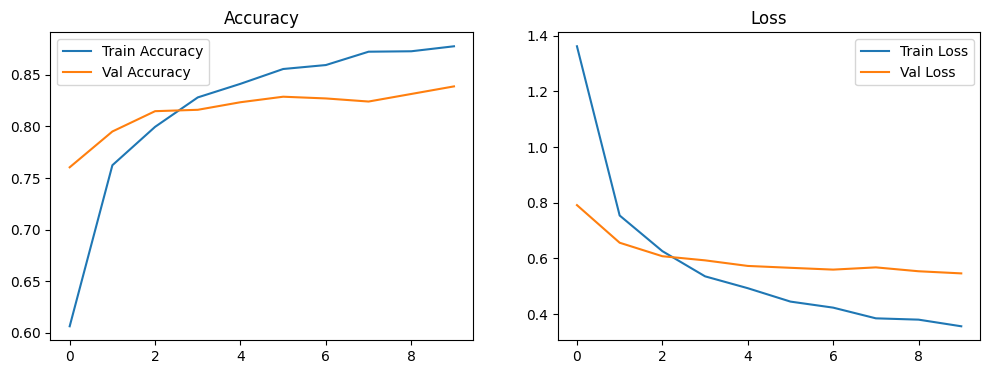

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [13]:
model.save("waste_classification_model.h5")
print("Model saved as waste_classification_model.h5")


Model saved as waste_classification_model.h5


In [14]:
# Path to a test image
img_path = r"C:\Users\Guman Behera\Downloads\Recycle waste classification\images\images\steel_food_cans\real_world\Image_1.png"

# Load and preprocess image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)

# Decode prediction
predicted_class = class_names[np.argmax(pred)]
waste_type = waste_type_mapping.get(predicted_class, "Unknown")

print("Predicted class:", predicted_class)
print("Waste type:", waste_type)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Predicted class: steel_food_cans
Waste type: Recyclable


In [15]:
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Class names saved.")


Class names saved.
